# **Secondary Stock Data - Feature Filtering and Optimization Using Correlation Matrix and VIF Notebook**
## In this notebook we will take our secondary stock data that has been previously preprocessed in sec_stock_preprocessing.ipynb and apply a method called VIF (Variance Inflation Factor) as well as a triangular correlation matrix to optimize our list of lagged features based on our target of the Closing Price for our data.  In other parts of this project it has been shown that there is extremely high collinearity with a lot of our features with our target, creating a lot of data leakage.  This will really skew our model results, so it is something we need to look at now before we get too far along.  Once we optimize our features our models will be much more efficient, as well as using this refined list of features to generate our secondary stocks for better cointegration tests at later parts of the project. 

#### As usual let's start by bringing in the libraries and logic necessary for reading in our file.

In [1]:

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

#### Now let's read in our notebook and take a look; we will need the scaled version of our preprocessed secondary stock data to start with for our PCA.

In [2]:
# Now let's access the main core_stock_data.csv file
csv_path = os.path.join(project_root, 'data', 'sec_stock_preprocessed.csv')
sec_stock_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
print(sec_stock_data.head())
print(sec_stock_data.shape)

            Close_sec  Volume_sec  Open_sec  High_sec   Low_sec   SMA_sec  \
Date                                                                        
2019-03-14  -0.160076   -0.558310 -0.144806 -0.158242 -0.146533 -0.116932   
2019-03-15  -0.166243    0.087049 -0.160989 -0.166353 -0.153977 -0.116932   
2019-03-18  -0.195843   -0.044652 -0.166278 -0.177272 -0.186554 -0.116932   
2019-03-19  -0.190798   -0.464214 -0.193156 -0.201280 -0.185235 -0.116932   
2019-03-20  -0.181681   -0.246529 -0.178433 -0.175411 -0.171332 -0.116932   

             EMA_sec   RSI_sec   BBM_sec   BBU_sec  ...  \
Date                                                ...   
2019-03-14 -0.155008  0.691244 -0.116932 -0.127101  ...   
2019-03-15 -0.155250  0.691244 -0.116932 -0.127101  ...   
2019-03-18 -0.156629  0.691244 -0.116932 -0.127101  ...   
2019-03-19 -0.157763  0.691244 -0.116932 -0.127101  ...   
2019-03-20 -0.158501  0.691244 -0.116932 -0.127101  ...   

            Momentum_7_Lag_Std_1_3_sec  Moment

#### We will first start with a PCA analysis to get the optimum features from our feature list of 153 present in our dataset.  We will then narrow it down using other optimization techniques.

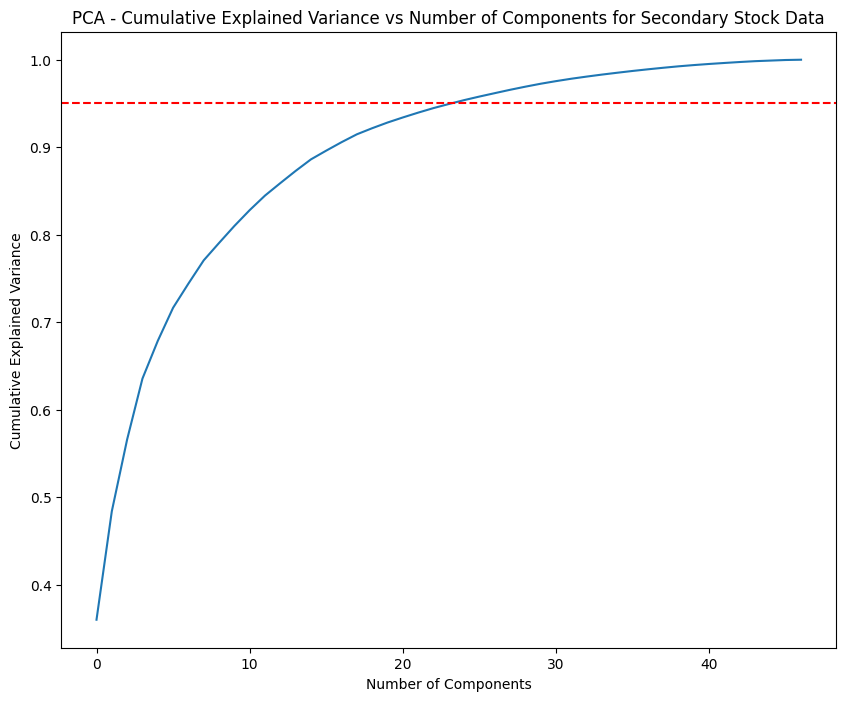

Number of components explaining 95% variance: 25


In [3]:
# Set up the X, y for the PCA.  As we run RFE and VIF down below we will be augmenting and editing our X for unnecessary features and re-running the processes.
X = sec_stock_data.drop(columns = ['Close_sec', 'ticker', 'Low_sec', 'High_sec', 'Open_sec',
                                'Open_sec_Lag_1', 'Open_sec_Lag_2', 'Open_sec_Lag_3',
                                'High_sec_Lag_1', 'High_sec_Lag_2', 'High_sec_Lag_3',
                                'Low_sec_Lag_1', 'Low_sec_Lag_2', 'Low_sec_Lag_3',
                                'Close_sec_Lag_1', 'Close_sec_Lag_2', 'Close_sec_Lag_3',
                                'Open_Lag_Avg_1_3_sec', 'High_Lag_Avg_1_3_sec', 'Low_Lag_Avg_1_3_sec', 'Close_Lag_Avg_1_3_sec',
                                'SMA_sec', 'EMA_sec', 'BBM_sec', 'BBU_sec', 'BBL_sec',
                                'EMA_sec_Lag_1', 'EMA_sec_Lag_2', 'EMA_sec_Lag_3',
                                'SMA_sec_Lag_1', 'SMA_sec_Lag_2', 'SMA_sec_Lag_3',
                                'BBM_sec_Lag_1', 'BBM_sec_Lag_2', 'BBM_sec_Lag_3',
                                'BBL_sec_Lag_1', 'BBL_sec_Lag_2', 'BBL_sec_Lag_3',
                                'BBU_sec_Lag_1', 'BBU_sec_Lag_2', 'BBU_sec_Lag_3',
                                'EMA_Lag_Avg_1_3_sec', 'SMA_Lag_Avg_1_3_sec', 'BBM_Lag_Avg_1_3_sec', 'BBU_Lag_Avg_1_3_sec', 'BBL_Lag_Avg_1_3_sec',
                                'Volume_Lag_Avg_1_3_sec', 'MACD_sec_Lag_1', 'ATR_14_sec', 'ATR_14_Lag_Avg_1_3_sec',
                                'RSI_Lag_Avg_1_3_sec', 'ATR_14_sec_Lag_1', 'ATR_14_sec_Lag_2', 'MACD_Lag_Avg_1_3_sec',
                                'MACD_sec_Lag_2', 'MACD_Lag_Avg_1_3_sec', 'Stoch_D_Lag_Avg_1_3_sec',
                                'Ratio_Close_EMA_sec', 'MACD_Signal_sec_Lag_2', 'MACD_Signal_sec_Lag_3',
                                'SMA_Lag_Std_1_3_sec', 'BBM_Lag_Std_1_3_sec', 'MACD_Signal_Lag_Avg_1_3_sec',
                                'CCI_20_sec', 'ADX_14_sec_Lag_2', 'ADX_14_sec_Lag_3', 'Momentum_50_Lag_Avg_1_3_sec',
                                'Stoch_D_sec', 'Stoch_K_sec', 'Stoch_K_sec_Lag_1', 'Stoch_K_sec_Lag_2',
                                'ADX_14_sec_Lag_1', 'Momentum_3_sec_Lag_1',
                                'Momentum_1_Lag_Avg_1_3_sec', 'CCI_20_Lag_Std_1_3_sec', 'ADX_14_Lag_Avg_1_3_sec',
                                'Stoch_D_sec_Lag_1', 'Stoch_K_Lag_Avg_1_3_sec', 'RSI_Lag_Std_1_3_sec',
                                'OBV_sec_Lag_2', 'CCI_20_sec_Lag_1', 'Momentum_30_sec_Lag_2', 'OBV_sec_Lag_2',
                                'MACD_Signal_sec', 'MACD_sec', 'MACD_Signal_sec_Lag_1',
                                'MACD_Hist_sec_Lag_2', 'MACD_Hist_Avg_1_3_sec', 'RSI_sec_Lag_3', 'CCI_20_Lag_Avg_1_3_sec',
                                'CCI_20_sec_Lag_2', 'OBV_Lag_Std_1_3_sec', 'Stoch_D_sec_Lag_2', 'Stoch_D_sec_Lag_3', 'CCI_20_sec_Lag_3',
                                'MACD_Hist_sec_Lag_1', 'Momentum_50_sec_Lag_2', 'Momentum_30_Lag_Avg_1_3_sec',
                                'RSI_sec', 'Volume_sec_Lag_1', 'Volume_sec_Lag_2', 'Volume_sec_Lag_3', 'Volume_sec',
                                'Close_Lag_Std_1_3_sec', 'RSI_sec_Lag_1', 'RSI_sec_Lag_2', 'Momentum_7_sec_Lag_2', 'Momentum_7_Lag_Avg_1_3_sec'
                                ])


y = sec_stock_data['Close_sec']

# Now fit the PCA.  Its already scaled, so we can just fit on X
pca = PCA().fit(X)

# Now plot to see results.
plt.figure(figsize = (10, 8))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance vs Number of Components for Secondary Stock Data')
plt.axhline(y = 0.95, color = 'r', linestyle = '--')
plt.show()

n_components_optimal = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components_optimal}")

#### Good start, we have determined that 25 features is optimal in explaining 95% of the variance in our data.  We will keep this in mind as we move on to the next phase of this notebook and use that number for the RFE (Recursive Feature Elimination).

#### The RFE uses Linear Regression, and will run through the features removing less important ones until it gets to the target feature number selected.

In [4]:
# We will set up our RFE just like a Linear Regression model, only the RFE acts as a wrapper.
linreg = LinearRegression()
rfe = RFE(linreg, n_features_to_select = 25) # Here we use the same number of features suggested from our PCA.
rfe.fit(X, y)

selected_rfe_features = X.columns[rfe.support_]
print(f"Selected features from RFE: {selected_rfe_features}")


Selected features from RFE: Index(['OBV_sec', 'MACD_Hist_sec_Lag_3', 'ATR_14_sec_Lag_3',
       'Momentum_1_sec_Lag_2', 'Momentum_1_sec_Lag_3', 'Momentum_7_sec_Lag_3',
       'Momentum_50_sec_Lag_1', 'Momentum_50_sec_Lag_3', 'OBV_sec_Lag_3',
       'Open_Lag_Std_1_3_sec', 'High_Lag_Std_1_3_sec', 'Low_Lag_Std_1_3_sec',
       'Volume_Lag_Std_1_3_sec', 'EMA_Lag_Std_1_3_sec', 'BBU_Lag_Std_1_3_sec',
       'BBL_Lag_Std_1_3_sec', 'MACD_Lag_Std_1_3_sec',
       'MACD_Signal_Lag_Std_1_3_sec', 'MACD_Hist_Lag_Std_1_3_sec',
       'ATR_14_Lag_Std_1_3_sec', 'Momentum_1_Lag_Std_1_3_sec',
       'Momentum_3_Lag_Avg_1_3_sec', 'Momentum_30_Lag_Std_1_3_sec',
       'Momentum_50_Lag_Std_1_3_sec', 'Diff_Close_EMA_sec'],
      dtype='object')


In [5]:
# Let's set up our VIF Calculation here.  we will make it as a function so we can tune our threshold as needed.
# We first will need to take our selected features and rebuild as a dataframe.
X_vif_features = X.iloc[:, rfe.support_]

# Confirming shape and creation of X_vif_features
print(f"Shape of X_vif_features: {X_vif_features.shape}")

# Now we create the VIF calculator
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif_features.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif_features.values, i) for i in range(X_vif_features.shape[1])]

print(vif_data)

# Handle infinite VIF values by filtering them our
filtered_vif_data = vif_data[vif_data['VIF'] != float('inf')]

# Set VIF threshold (to be edited as we make multiple runs of this)
vif_threshold = 10

# Filter the features based on the threshold
final_vif_data = filtered_vif_data[filtered_vif_data['VIF'] < vif_threshold]
final_vif_features = final_vif_data['Feature']

sorted_final_vif_data = final_vif_data.sort_values(by = 'VIF', ascending=False)
print(f"Sorted final features:\n{sorted_final_vif_data[['Feature', 'VIF']]}")




Shape of X_vif_features: (266665, 25)
                        Feature       VIF
0                       OBV_sec  9.175347
1           MACD_Hist_sec_Lag_3  3.420436
2              ATR_14_sec_Lag_3  7.285241
3          Momentum_1_sec_Lag_2  1.806437
4          Momentum_1_sec_Lag_3  2.250447
5          Momentum_7_sec_Lag_3  3.039950
6         Momentum_50_sec_Lag_1  9.345035
7         Momentum_50_sec_Lag_3  7.772605
8                 OBV_sec_Lag_3  9.127552
9          Open_Lag_Std_1_3_sec  7.711903
10         High_Lag_Std_1_3_sec  7.531119
11          Low_Lag_Std_1_3_sec  7.491667
12       Volume_Lag_Std_1_3_sec  1.355514
13          EMA_Lag_Std_1_3_sec  4.988330
14          BBU_Lag_Std_1_3_sec  3.435816
15          BBL_Lag_Std_1_3_sec  3.315494
16         MACD_Lag_Std_1_3_sec  6.875065
17  MACD_Signal_Lag_Std_1_3_sec  4.948516
18    MACD_Hist_Lag_Std_1_3_sec  4.466413
19       ATR_14_Lag_Std_1_3_sec  2.742488
20   Momentum_1_Lag_Std_1_3_sec  4.852029
21   Momentum_3_Lag_Avg_1_3_sec  3.086

#### We have a final list of 25 features, down from our original 153, that have been optimized according to our target according to their rate of collinearity.  Due to time restrictions we will just manually implement these in various areas in our project for now.  Later as time allows we will explore other methodologies (RFECV/Ridge, Boruta with RandomForest, etc.) to see if the results differ.

#### We have tested and filtered for multicollinearity, however we need to make sure we didn't remove features that carry predictability with our target.  Let's look at a MIS (Mutual Information Scores) Regression model real quick to ascertain the predictive power of each of the remaining features.  We will want to establish a balance between collinearity and prediction power for our final set of features.

In [9]:
# Set up the MI model (Mutual Information Scores)
mi_scores = mutual_info_regression(X_vif_features, y)

# Create a new dataframe to display our feature names and score
mi_scores_df = pd.DataFrame({
    'Feature' : X_vif_features.columns,
    'MI_Score' : mi_scores
})

# Sort the dataframe by MI scores in descending order
mi_scores_df = mi_scores_df.sort_values(by= 'MI_Score', ascending = False)

print(f"Mutual Information Scores for selected features: {mi_scores_df}")

average_mi_score = mi_scores_df['MI_Score'].mean()
print(f"Average MI Score: {average_mi_score}")


Mutual Information Scores for selected features:                         Feature  MI_Score
2              ATR_14_sec_Lag_3  0.992759
20   Momentum_1_Lag_Std_1_3_sec  0.462248
9          Open_Lag_Std_1_3_sec  0.442445
22  Momentum_30_Lag_Std_1_3_sec  0.434250
23  Momentum_50_Lag_Std_1_3_sec  0.430312
11          Low_Lag_Std_1_3_sec  0.417953
10         High_Lag_Std_1_3_sec  0.406808
13          EMA_Lag_Std_1_3_sec  0.395646
18    MACD_Hist_Lag_Std_1_3_sec  0.390851
0                       OBV_sec  0.381763
16         MACD_Lag_Std_1_3_sec  0.370042
19       ATR_14_Lag_Std_1_3_sec  0.362153
17  MACD_Signal_Lag_Std_1_3_sec  0.335695
8                 OBV_sec_Lag_3  0.319678
6         Momentum_50_sec_Lag_1  0.311051
7         Momentum_50_sec_Lag_3  0.305910
24           Diff_Close_EMA_sec  0.295783
14          BBU_Lag_Std_1_3_sec  0.251224
15          BBL_Lag_Std_1_3_sec  0.247240
12       Volume_Lag_Std_1_3_sec  0.209242
5          Momentum_7_sec_Lag_3  0.201350
21   Momentum_3_Lag_Avg_1_3

#### Let's also plot the scores we just retrieved from our MIS to see them as well.

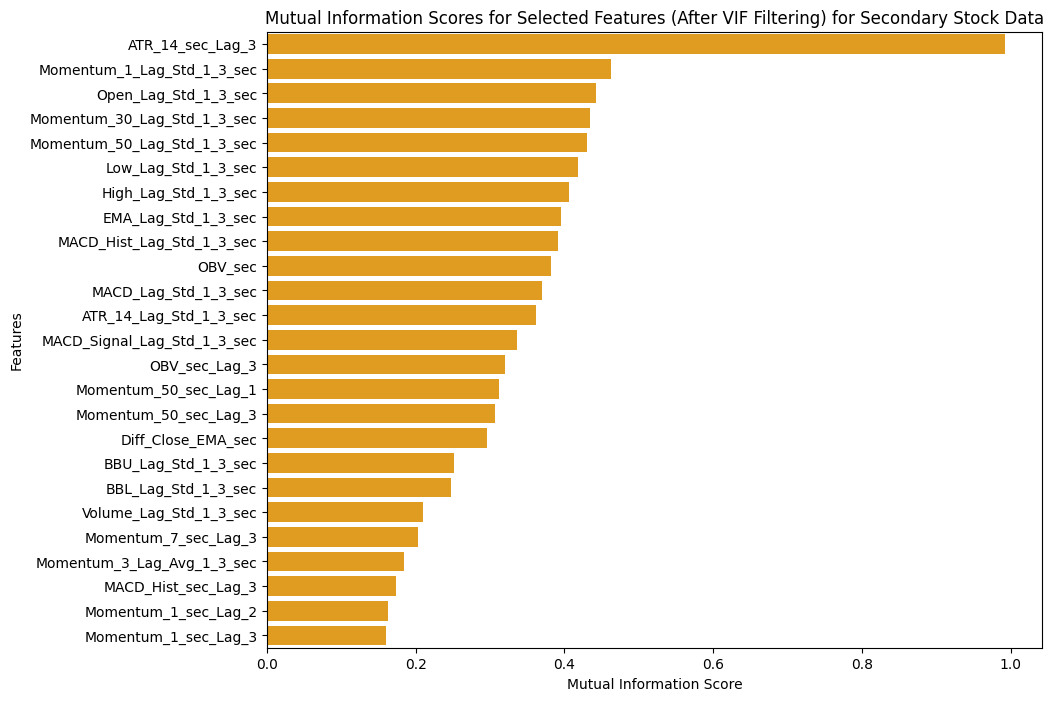

In [7]:
plt.figure(figsize = (10,8))

sns.barplot(x = 'MI_Score', y = 'Feature', data = mi_scores_df, color = 'orange')
plt.title('Mutual Information Scores for Selected Features (After VIF Filtering) for Secondary Stock Data')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

#### This is what I was aiming for, where we have a solid list of our filtered VIF features that we can show also predict well to our target in Close_sec.  Note multiple prunings have been made in order to acquire the end product above, where I would compare MIS feature scores and VIF feature scores and see which VIF scores were highest as well as which of the same features had noticeably low MIS scores.  I then dropped them, and lowered the VIF threshold until I obtained the desired '10' as well as the MIS balance for the final set of features.

#### In this notebook we used correlation matrix and VIF (Variance Inflation Factor) to filter down and score our features against our target feature in Closing Price (Close_Sec), then used afterwards MIS (Mutual Information Scores) to make sure our selected features from VIF had stable predictability.  We ended up with 10 features that we will manually implement where needed now in our project.